# Metody Obliczeniowe w Nauce i Technice
## Laboratorium 6 - Rozwiązywanie układów równań liniowych
### Albert Gierlach

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; 
}

<IPython.core.display.Javascript object>

In [2]:
from copy import copy
import numpy as np
import scipy.linalg
import time
from matplotlib import pyplot as plt
import networkx as nx
import random
import matplotlib as mtplt
from numpy.linalg import LinAlgError

mtplt.rcParams['figure.figsize'] = [18, 9] # plots size

#### 1. Metoda Gaussa-Jordana

Na samym początku zaimplementowałem kod metody Gaussa-Jordana na podstawie pseudokodu.

In [3]:
# Ax = b
def gauss_jordan_alg(e):
    eps = 1.0e-20
    n, m = e.shape
    equation = np.copy(e)

    for j in range(n):
        # search for maxpivot
        maxpivot = j
        for i in range(j + 1, n):
            if np.fabs(equation[i, j]) > np.fabs(equation[maxpivot, j]):
                maxpivot = i

        if np.fabs(equation[maxpivot, j]) < eps:
            # singular matrix
            return equation[:, n]

        # swap rows
        equation[maxpivot, :], equation[j, :] = copy(equation[j, :]), copy(equation[maxpivot, :])
        # equation[maxpivot, :], equation[j, :] = equation[j, :], equation[maxpivot, :]

        pivot = equation[j, j]
        equation[j, :] /= pivot  # scale by pivot
        for i in range(n):
            if i == j:
                continue
            equation[i, :] = equation[i, :] - equation[i, j] * equation[j, :]

    return equation[:, n]

Następnie porównam czasy dla algorytmów numpy.linalg.solve, numpy.linalg.lstsq oraz mojej implementacji metody Gaussa-Jordana. W tym celu zadeklaruje dwie metody pomocnicze do tworzenia układu równań oraz do pomiaru czasu, a następnie stworzę docelową funkcję pomiarową, która sprawdza także poprawność otrzymanych wyników.

In [4]:
def get_random_equation(n):
    return np.random.uniform(low=-50.0, high=50.0, size=(n, n + 1))


def timeit(func):
    startTime = time.perf_counter()
    return func(), round(time.perf_counter() - startTime, 3)

In [5]:
times = [[] for _ in range(3)]
ns = []
format_str = "|{:^5}|{:^10}|{:^10}|{:^10}|"
print(format_str.format("n", "my func", "linalg", "lstsq"))
for n in range(500, 901, 50):
    equation = get_random_equation(n)
    t = [0] * 3
    gauss_jordan, t[0] = timeit(lambda: gauss_jordan_alg(equation))
    linalg, t[1] = timeit(lambda: np.linalg.solve(equation[:, 0:n], equation[:, n]))
    lstsq, t[2] = timeit(lambda: np.linalg.lstsq(equation[:, 0:n], equation[:, n], rcond=-1)[0])
    if not np.allclose(gauss_jordan, linalg) or not np.allclose(gauss_jordan, lstsq):
        print("Bad solution! {}".format(n))

    print(format_str.format(n, str(t[0]) + 's', str(t[1]) + 's', str(t[2]) + 's'))
    for i in range(3):
        times[i].append(t[i])
    ns.append(n)

|  n  | my func  |  linalg  |  lstsq   |
| 500 |  2.733s  |  0.02s   |  0.158s  |
| 550 |  2.116s  |  0.028s  |  0.305s  |
| 600 |  3.81s   |  0.028s  |  0.241s  |
| 650 |  4.453s  |  0.031s  |  0.286s  |
| 700 |  4.937s  |  0.033s  |  0.338s  |
| 750 |  5.441s  |  0.038s  |  0.395s  |
| 800 |  5.987s  |  0.038s  |  0.453s  |
| 850 |  6.649s  |  0.04s   |  0.513s  |
| 900 |  8.652s  |  0.043s  |  0.585s  |


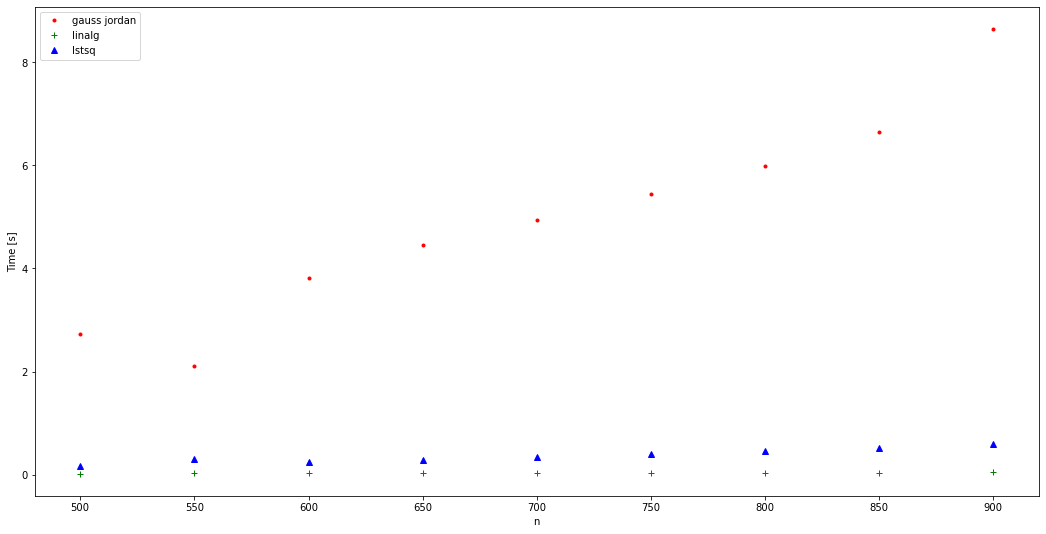

In [6]:
plt.plot(ns, times[0], 'r.', label="gauss jordan")
plt.plot(ns, times[1], 'g+', label="linalg")
plt.plot(ns, times[2], 'b^', label="lstsq")
plt.xlabel("n")
plt.ylabel("Time [s]")
plt.legend()
plt.show()

Jak pokazują powyższe wyniki złożoność algorytmu Gaussa-Jordana jest znacznie gorsza niż metody linalg.solve oraz linalg.lstsq. Czas potrzebny do rozwiązania rośnie wraz ze wzrostem liczby równań do rozwiązania. Wykres pokazuje także, że metoda linalg.solve jest najszybsza w rozwiązywaniu układów równań.

#### 2. Faktoryzacja LU

Zaimplementowałem funkcję, która dokonuje faktoryzację macierzy A na macierze L (dolnotrójkątną) oraz U (górnotrójkątną). Funkcja kopiuje przekazaną macierz, aby unikać jej modyfikacji, gdyż będzie to przydatne w sprawdzaniu poprawności. Metoda wykorzystuje skalowanie oraz częściowy pivoting.

In [7]:
def lu_factor(A_orig):
    A = np.copy(A_orig)  # preserve original matrix
    n = A.shape[0]
    pivot = np.arange(0, n)
    for k in range(n - 1):
        # find pivot
        m_row = np.argmax(abs(A[k:n, k])) + k  # max row
        pivot[[k, m_row]] = pivot[[m_row, k]]
        A[[k, m_row]] = A[[m_row, k]]  # swap

        # eliminate
        for i in range(k + 1, n):
            A[i, k] = A[i, k] / A[k, k]
            for j in range(k + 1, n):
                A[i, j] -= A[i, k] * A[k, j]

    # extract triangular matrices
    L = np.tril(A)
    U = np.triu(A)
    for i in range(n):
        L[i][i] = 1

    return L, U

In [8]:
def get_random_square_matrix(n):
    return np.random.uniform(low=-30.0, high=30.0, size=(n, n))

In [9]:
format_str = "|{:^5}|{:^9}|"
print(format_str.format("n", "correct?"))
for n in [3, 50, 100, 300]:
    A = get_random_square_matrix(n)
    (P, L, U) = scipy.linalg.lu(A)
    (L2, U2) = lu_factor(A)

    correct = np.allclose(L, L2) and np.allclose(U, U2)
    print(format_str.format(n, "yes" if correct else "no"))

|  n  |correct? |
|  3  |   yes   |
| 50  |   yes   |
| 100 |   yes   |
| 300 |   yes   |


Do sprawdzenia poprawności wyników użyłem metody allclose() z biblioteki numpy. Jak widać otrzymane wyniki zgadzają się z tymi zwracanymi przez scipy.linalg.lu

#### 3 Analiza obwodu elektrycznego

Do zarządzania grafami zdecydowałem się wykorzystać bibliotekę networkx (po nieudanej próbie z biblioteką igraph). Pozwoliłem sobie nie walidować danych wejściowych. Na początku zastosuję drugie prawo Kirchhoffa dotyczące sum napięć w oczku. Do znajdowania oczek w obwodzie, użyłem cycle_basis z biblioteki networkx, która zwraca najmniejszą kolekcję cykli. Cykle zostały 'domknięte' manualnie. Trójka liczb określająca SEM jest pierwszym wierszem w pliku z danymi grafu.

In [10]:
def draw_graph(G, layout, title):
    plt.figure(title)
    nx.draw_networkx_nodes(G, layout,
                           node_color='black',
                           node_size=500)

    nx.draw_networkx_edges(G, layout, width=1.7, alpha=0.5)
    nx.draw_networkx_labels(G, layout, font_size=10, font_color="white", font_weight='bold')
    nx.draw_networkx_edge_labels(G, layout, edge_labels={k: str(round(v, 2)) + 'A' for k, v in
                                              nx.get_edge_attributes(G, 'I').items()})

    plt.axis('off')
    plt.title(title)
    plt.draw()

Główna funkcja obliczająca natężenia polega na metodzie oczkowej. Najpierw wykorzystuję cykle (oczka), aby ułożyć początkową ilość równań, a potem dopełniam macierz z równaniami równaniami bazującymi na prawie Kirchhoffa dotyczącym napięć. Gdy obliczenia zostaną wykonane, modyfikuję graf tak, by dla każdej krawędzi przechowywać informację jakie jest natężenie prądu w danej krawędzi (gałęzi) grafu (obwodu).

In [11]:
def solve_graph_kirchhoff(G, s, t, E):
    G.add_edge(s, t, R=0)
    edges_num = G.number_of_edges()
    # Ax = b
    A = np.zeros((edges_num, edges_num))
    B = np.zeros(edges_num)

    # create loops, and calculate voltages
    # for each cycle sum of voltages will be 0
    cycles = nx.cycle_basis(G.to_undirected())
    cycles_len = len(cycles)
    edges_list = list(G.edges())
    edges_list_len = G.number_of_edges()
    for cycle_index, cycle in enumerate(cycles):
        for edge in zip(cycle, cycle[1:] + [cycle[0]]):  # close cycle, and create pairs
            if edge == (s, t):
                B[cycle_index] = E
            elif edge == (t, s):
                B[cycle_index] = -E
            else:
                (a, b) = (edge[0], edge[1])
                if edge in edges_list:
                    col = edges_list.index(edge)
                    A[cycle_index][col] = G[a][b]['R']
                else:  # reversed edge
                    col = edges_list.index((b, a))
                    A[cycle_index][col] = -G[b][a]['R']

    for i, node in enumerate(G.nodes()):
        index = cycles_len + i  # might be off by one error
        if index == edges_list_len:  # we have enough equations!
            break

        for edge in G.in_edges(node):  # add in edges
            col = edges_list.index(edge)
            A[index][col] = 1

        for edge in G.out_edges(node):  # sub out edges
            col = edges_list.index(edge)
            A[index][col] = -1

    I = np.linalg.solve(A, B)

    for i, edge in enumerate(edges_list):
        (a, b) = edge
        if I[i] < 0:  # we need to reverse edge
            orig_R = G[a][b]["R"]
            G.remove_edge(a, b)
            G.add_edge(b, a, R=orig_R, I=abs(I[i]))
        else:
            G[a][b]["I"] = I[i]


    return G

Zaimplementowałem drugą metodę opartą na metodzie potencjałów węzłowych.

In [12]:
def solve_graph_nodal(G, s, t, E):
    G.add_edge(s, t, R=1)
    u_dict = {v: None for v in G.nodes}
    u_dict[s] = 0
    u_dict[t] = E
    nx.set_node_attributes(G, u_dict, "U")

    # Ax = b
    edges_num = G.number_of_nodes()
    A = np.zeros((edges_num, edges_num))
    b = np.zeros(edges_num)
    for node_idx in G.nodes:
        if G.nodes[node_idx]["U"] is not None:
            A[node_idx][node_idx] = 1
            b[node_idx] = G.nodes[node_idx]["U"]
        else:  # we need to calculate
            for k, v in G[node_idx].items():
                rev_R = 1 / v["R"]
                A[node_idx][node_idx] += rev_R
                A[node_idx][k] -= rev_R

    U = np.linalg.solve(A, b)
    for node_idx in G.nodes:
        G.nodes[node_idx]["U"] = U[node_idx]

    G_out = nx.DiGraph()
    for node_idx in G.nodes:
        for k, v in G[node_idx].items():
            I = (G.nodes[node_idx]["U"] - G.nodes[k]["U"]) / v["R"]
            if I > 0:
                G_out.add_edge(node_idx, k, I=I, R=v["R"])
            else:
                G_out.add_edge(k, node_idx, I=abs(I), R=v["R"])

    # just reverse SEM edge, only for printing
    try:
        orig_dict = dict(G_out[t][s])
    except:
        orig_dict = {}
    try:
        G_out.remove_edge(t, s)
        G_out.add_edge(s, t, **orig_dict)
    except:
        pass

    G_out[s][t]["I"] = sum([G_out.edges[node]["I"] for node in G_out.in_edges(s)])

    return G_out

Procedura weryfikacji obliczeń jest bardzo podobna do powyższej funkcji, z tą różnicą, że sprawdzamy tylko prawa Kirchhoffa i zwracamy True lub False

In [13]:
def verify_graph(G, s, t, E):
    eps = 1e-6
    # just check two kirchhoff laws
    for node in G.nodes():
        if node == s or node == t:
            continue

        In = sum([G.edges[e]["I"] for e in G.in_edges(node)])
        Iout = sum([G.edges[e]["I"] for e in G.out_edges(node)])

        if abs(In - Iout) > eps:
            return False

    for cycle_index, cycle in enumerate(nx.cycle_basis(G.to_undirected())):
        U = 0
        for edge in zip(cycle, cycle[1:] + [cycle[0]]):  # close cycle, and create pairs
            if edge == (s, t):
                U += E
            elif edge == (t, s):
                U += -E
            else:
                if edge in G.edges():
                    U -= G.edges[edge]["R"] * G.edges[edge]["I"]
                else:  # reversed edge
                    edge = (edge[1], edge[0])
                    U += G.edges[edge]["R"] * G.edges[edge]["I"]

        if U > eps:
            return False

    return True

In [14]:
def solve_graph_wrapper(G, tpl, pos):
    (s, t, E) = tpl
    # kirchhoff
    solvedG = solve_graph_kirchhoff(G.copy(), s, t, E)
    res = verify_graph(solvedG, s, t, E)
    print("Kirchoff solution correct?: {}".format(res))
    draw_graph(solvedG, pos, "Kirchhoff")

    # nodal analysis method
    solvedG2 = solve_graph_nodal(G.copy().to_undirected(), s, t, E)
    res = verify_graph(solvedG2, s, t, E)
    draw_graph(solvedG2, pos, "Nodal analysis")
    print("Nodal analysis solution correct?: {}".format(res))

    plt.show()

Do generowania grafów użyłem własnego generatora (wspierając się biblioteką networkx), który ma opcję wczytywania grafów z pliku, a także generowania w locie. Do przedstawienia wyników skorzystam z generowania na bieżąco. Poniżej klasa generatora oraz przykłady wygenerowanych i rozwiązanych grafów wraz z weryfikacją poprawności. Może się zdarzyć, że macierz równań z wygenerowanego losowo grafu spowoduje błąd mówiący o tym, że macierz jest osobliwa. W takim przypadku należy ponownie uruchomić daną komórkę.

In [15]:
class Generator:
    # rather bad code, but... its generator after all
    data_dir = "./data/{}"

    def __init__(self):
        pass


    def load_graph(self, path):
        with open(Generator.data_dir.format(path), "r") as f:
            lines = f.read().splitlines()

        sem = tuple(int(part) for part in lines[0].split(' '))
        edges = [(int(x), int(y), dict(R=int(r))) for x, y, r in [k.split(' ') for k in lines[1:]]]

        G = nx.DiGraph()
        G.add_edges_from(edges)

        return G, (sem[i] for i in range(3)), nx.shell_layout(G)


    def generate_grid(self, n):
        edges = []
        max_node_num = n * n

        def check_and_append(i, s):
            if s < max_node_num and i < max_node_num:
                edges.append((i, s, {"R": random.randint(1, 10)}))

        for i in range(max_node_num):
            if i // n == (i + 1) // n:
                check_and_append(i, i + 1)
            check_and_append(i, i + n)

        G = nx.DiGraph()
        G.add_edges_from(edges)

        pos = {
            i: [i // n, -(i % n)] for i in range(n * n)
        }

        return G, (0, (n * n) - 1, random.randint(10, 100)), pos

    def generate_random(self, n):
        try:
            G, (s, t, E), l = self.generate_random_(n)
            solve_graph_kirchhoff(G.copy(), s, t, E)
            solve_graph_nodal(G.copy().to_undirected(), s, t, E)
            return G, (s, t, E), l
        except LinAlgError:
            return self.generate_random(n)

    def generate_random_(self, n):
        G = nx.DiGraph()
        for i in range(n):
            for j in range(i, n):
                if random.randint(1, 15) == 1:
                    G.add_edge(i, j, R=random.randint(1, 20))

        G.remove_nodes_from(list(nx.isolates(G)))
        G = nx.convert_node_labels_to_integers(G, first_label=0)
        random_nodes = random.sample(list(G.nodes()), 2)
        return G, (random_nodes[0], random_nodes[1], random.randint(10, 100)), nx.random_layout(G)


    def tri_cubic(self):
        G = nx.petersen_graph()
        edges_petersen = list(G.edges())
        G = nx.DiGraph()
        for a, b in edges_petersen:
            G.add_edge(a, b, R=random.randint(1,10))

        random_edge = random.choice(list(G.edges()))
        pos = {0: [-9, 2], 2: [9, 2], 1: [0, 8], 4: [-5, -10], 3: [5, -10],  # outer
               5: [-4, 0], 8: [3, -6], 9: [-3, -6], 6: [0, 3], 7: [4, 0]
               }

        return G, (random_edge[0], random_edge[1], random.randint(10, 50)), pos

    def bridge_graph(self):
        try:
            G, (s, t, E), l = self.bridge_graph_()
            solve_graph_kirchhoff(G.copy(), s, t, E)
            return G, (s, t, E), l
        except LinAlgError:
            return self.bridge_graph()


    def bridge_graph_(self):
        n = 12
        G1 = nx.DiGraph()
        G2 = nx.DiGraph()
        for i in range(n):
            for j in range(i, n):
                if random.randint(1, 3) == 1:
                    G1.add_edge(i, j, R=random.randint(1, 20))
                elif random.randint(1, 2) == 1:
                    G2.add_edge(i+n, j+n, R=random.randint(1, 20))

        G1.remove_nodes_from(list(nx.isolates(G1)))
        G2.remove_nodes_from(list(nx.isolates(G2)))
        G1 = nx.convert_node_labels_to_integers(G1, first_label=0)
        max_node_from_g1 = max(G1.nodes()) + 1
        G2 = nx.convert_node_labels_to_integers(G2, first_label=max_node_from_g1)

        rand_g1 = random.sample(list(G1.nodes()), 2)
        rand_g2 = random.sample(list(G2.nodes()), 2)

        G = nx.compose(G1, G2)
        for i in range(2):
            G.add_edge(rand_g1[i], rand_g2[i], R=40)

        pos1 = nx.shell_layout(G1)
        pos2 = nx.shell_layout(G2)
        pos1 = {k: [v[0]-2, v[1]-2] for k, v in pos1.items()}

        return G, (rand_g1[0], rand_g2[0], random.randint(10, 100)), {**pos1, **pos2}

gen = Generator()

Kirchoff solution correct?: True
Nodal analysis solution correct?: True


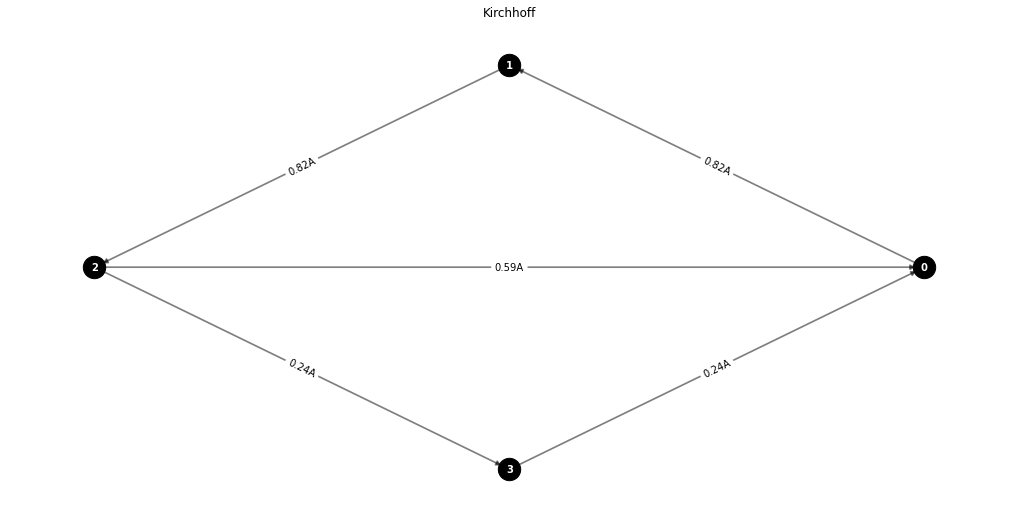

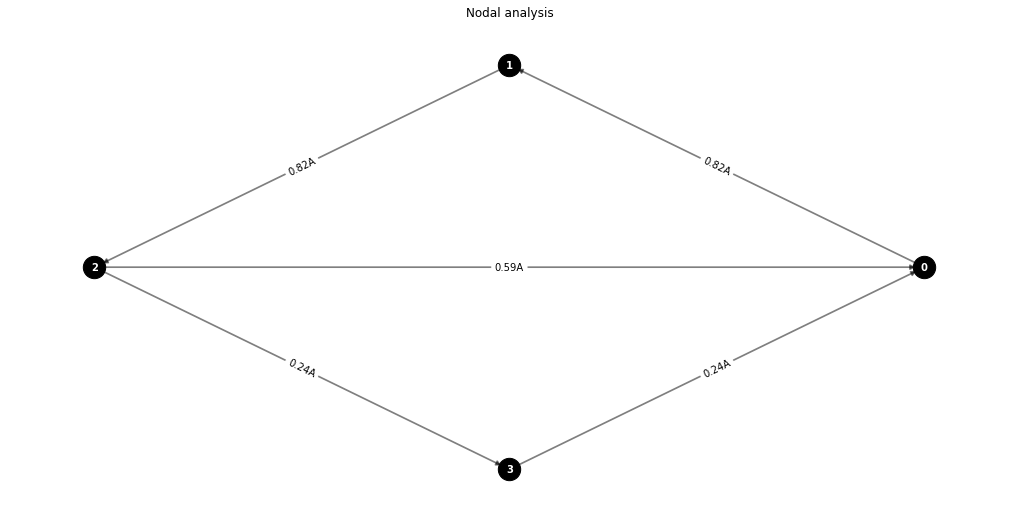

In [16]:
solve_graph_wrapper(*gen.load_graph("test.txt"))

Kirchoff solution correct?: True
Nodal analysis solution correct?: True


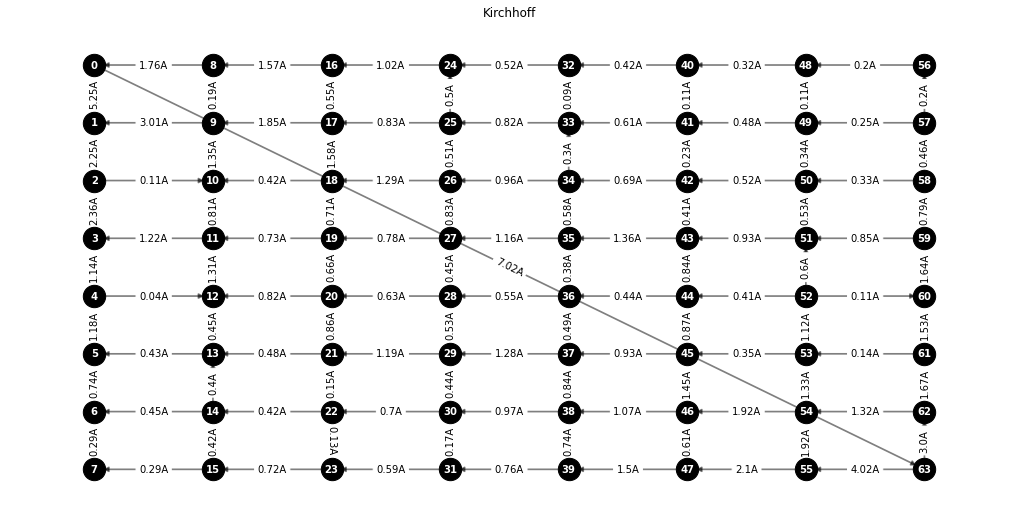

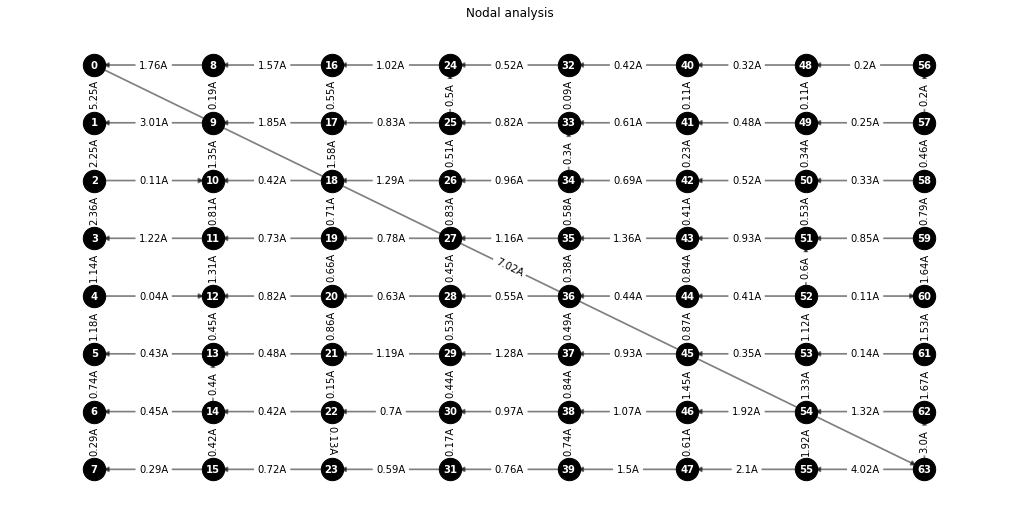

In [17]:
solve_graph_wrapper(*gen.generate_grid(8))

Kirchoff solution correct?: True
Nodal analysis solution correct?: True


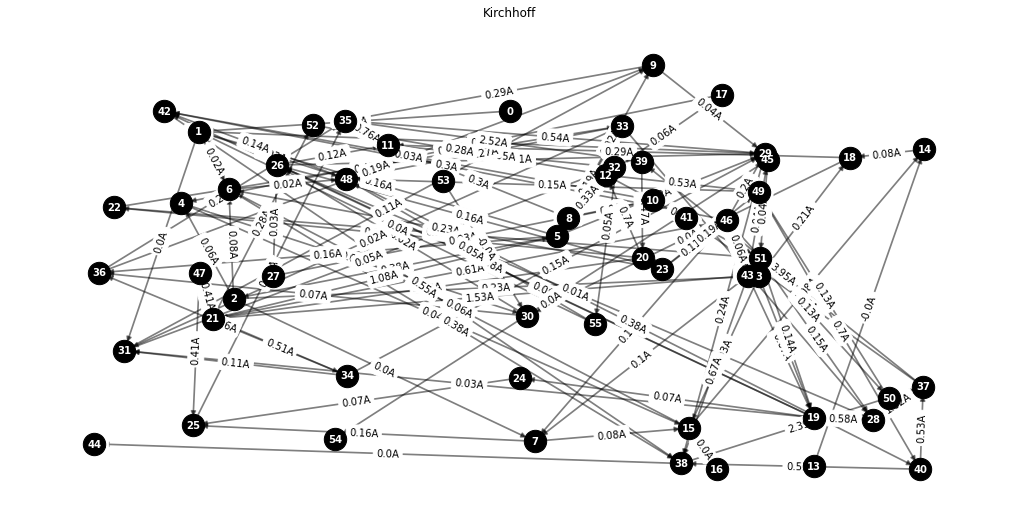

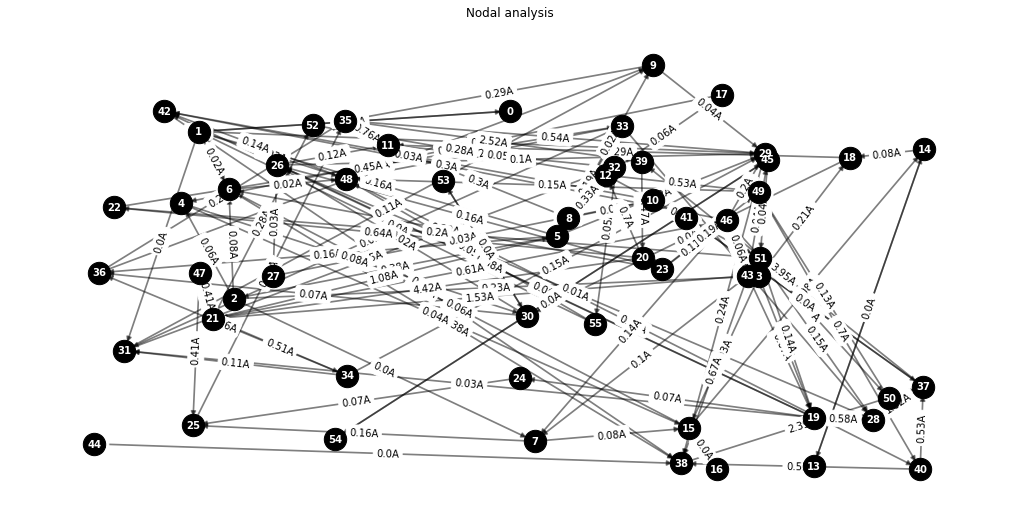

In [18]:
solve_graph_wrapper(*gen.generate_random(random.randint(25, 60)))

Kirchoff solution correct?: True
Nodal analysis solution correct?: True


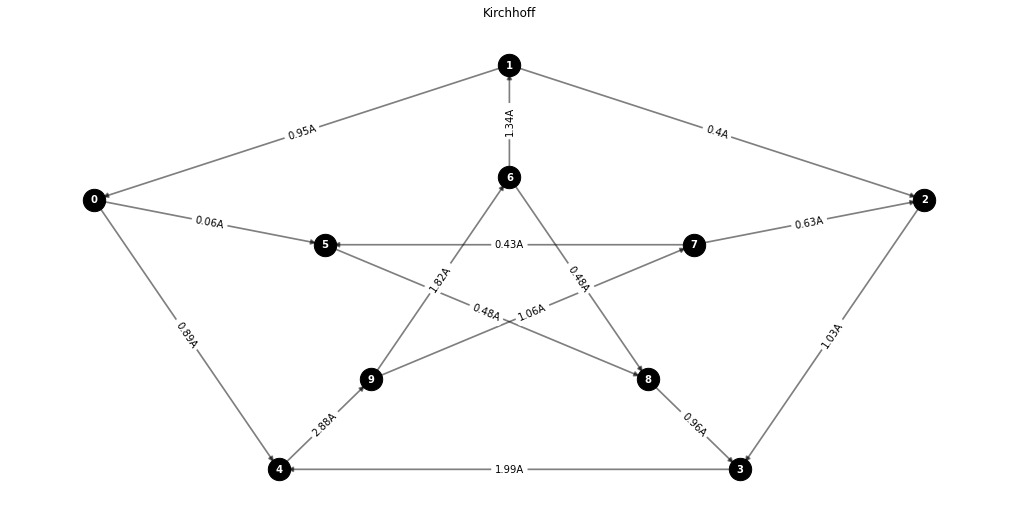

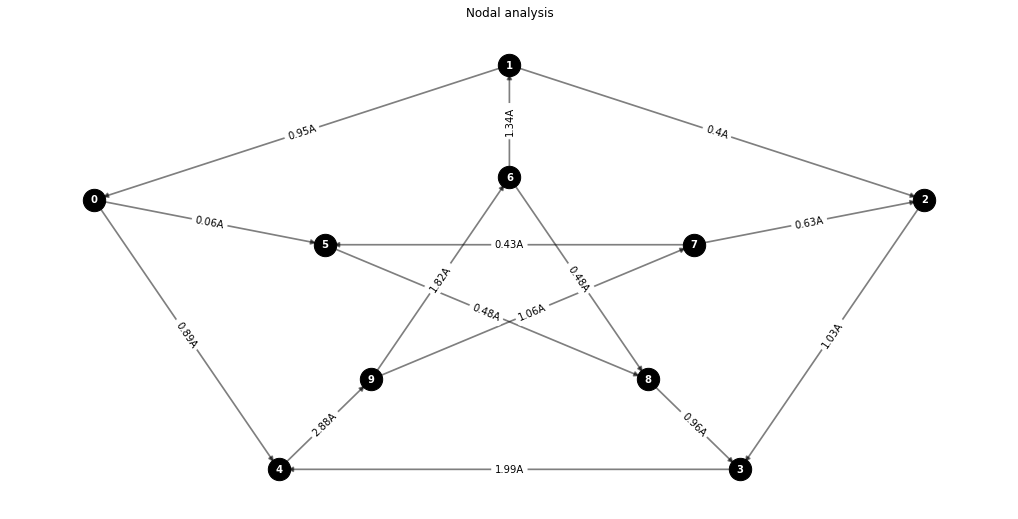

In [19]:
solve_graph_wrapper(*gen.tri_cubic())

Kirchoff solution correct?: True
Nodal analysis solution correct?: True


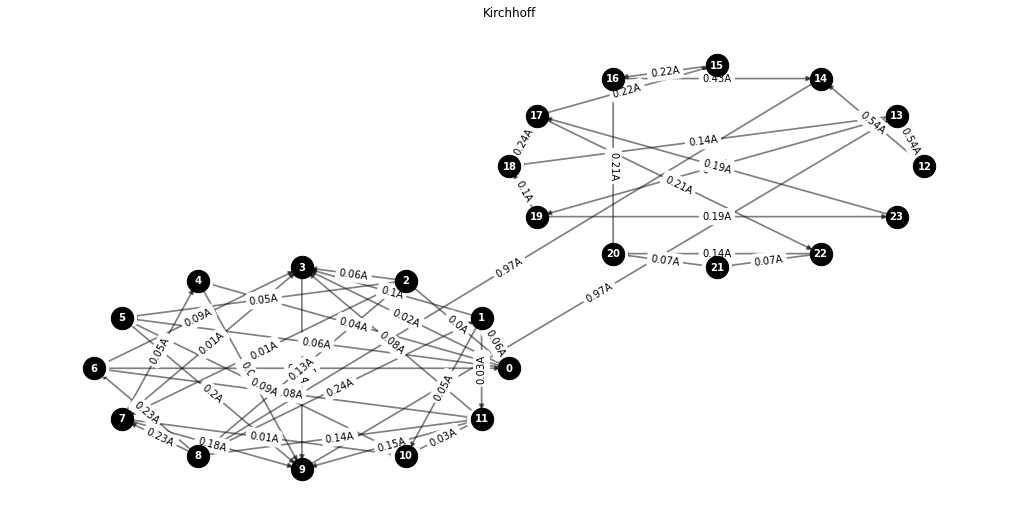

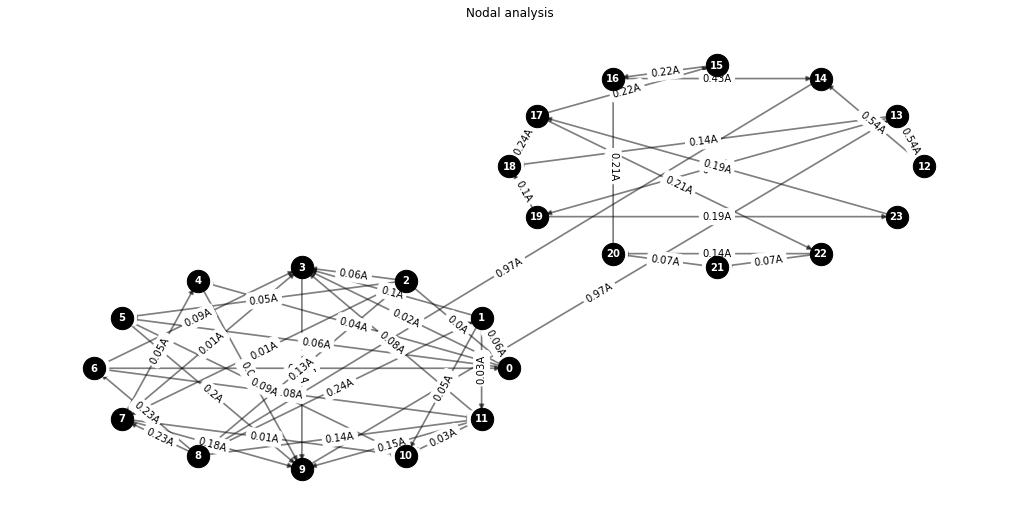

In [20]:
solve_graph_wrapper(*gen.bridge_graph())

### Źródła:
* [LU with pivoting](http://www.math.kent.edu/~reichel/courses/intr.num.comp.1/fall09/lecture9/lecture4.pdf)
* [Pivoting for LU Factorization](http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-reid-LU-pivoting.pdf)
* Numerical Mathematics and Computing, 7th Edition - Ward Cheney, David Kincaid
* [NetworkX](https://networkx.github.io/documentation/stable/index.html)
* [An Algorithm for Modified Nodal Analysis](https://www.swarthmore.edu/NatSci/echeeve1/Ref/mna/MNA3.html)
* [Electric Circuit Analysis/Nodal Analysis](https://en.wikiversity.org/wiki/Electric_Circuit_Analysis/Nodal_Analysis)
* [Wikipedia Nodal Analysis](https://en.wikipedia.org/wiki/Nodal_analysis)
